In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import joblib
import sys
sys.path.append("../")

from cfmining.algorithms import MAPOFCEM
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import GeneralClassifier_Shap
from cfmining.action_set import ActionSet
from cfmining.utils import get_data_model

import dice_ml


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
def summarize_results(results, perc_calc, outlier_detection = None, display_results = True):
    results["individual"] = results["individual"].apply(literal_eval)
    results["solutions"] = results["solutions"].apply(literal_eval)
    costs = []
    n_changes = []
    outliers = []
    outliers_score = []
    for i in range(len(results)):
        individual = results["individual"].iloc[i]
        if len(individual) == 1:
            individual = individual[0]
            
        criteria = PercentileCriterion(individual, perc_calc)
        solutions = results["solutions"].iloc[i]

        if len(solutions) == 0:
            costs.append(None)
            n_changes.append(None)
            outliers.append(None)
            outliers_score.append(None)
            continue
        costs_ = [criteria.f(s) for s in solutions][0]
        
        
        sol0 = results["solutions"].iloc[i][0]
        n_changes_ = sum([1 for i in range(len(individual)) if individual[i] != sol0[i]])

        n_changes.append(n_changes_)
        costs.append(costs_)
        if outlier_detection is not None:
            outliers_ = [outlier_detection.predict(np.array(s)[None, :]) == -1 for s in solutions][0][0]
            outliers.append(outliers_)
            outliers_score_ = np.mean([outlier_detection.score(np.array(s)[None, :]) for s in solutions])
            outliers_score.append(outliers_score_)
        else:
            outliers.append(False)
            outliers_score.append(1)
            
    results["costs"] = costs
    results["outlier"] = outliers
    results["n_changes"] = n_changes
    results["outliers_score"] = outliers_score

    if display_results:

        print(f"Time: {results['time'].mean():.3f} +- {results['time'].std():.3f}")
        print(f"Costs: {results['costs'].mean():.3f} +- {results['costs'].std():.3f}")
        print(f"Changes: {results['n_changes'].mean():.3f} +- {results['n_changes'].std():.3f}")
        print(f"Outliers: {results['outlier'].mean():.3f}")
        print(f"Outliers score: {results['outliers_score'].mean():.3f} +- {results['outliers_score'].std():.3f}")

        fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3))
        axs[0].scatter(
            results.sort_values("prob")["prob"],
            results.sort_values("prob")["time"],
        )
        axs[0].set_xlabel("Probability")
        axs[0].set_ylabel("Time (s)")

        axs[1].scatter(
            results.sort_values("prob")["prob"],
            results.sort_values("prob")["costs"],
        )
        axs[1].set_xlabel("Probability")
        axs[1].set_ylabel("Costs")

        plt.tight_layout()
        plt.show()
    else:
        return results

## German

In [87]:
X_train, Y_train, model, _, _ = get_data_model("german")
outlier_detection = joblib.load("../models/german/IsolationForest_test.pkl")

In [88]:
not_mutable_features = ['Age', 'OwnsHouse', 'isMale', 'JobClassIsSkilled', 'Single', 'ForeignWorker', 'RentsHouse']
mutable_features = [feat for feat in X_train.columns if feat not in not_mutable_features]
action_set = ActionSet(X = X_train, default_step_size = 0.01, mutable_features = mutable_features)
perc_calc = PercentileCalculator(X = X_train)

In [80]:
paths = "../results/german/"
methods = ["dice_1sol", "nice_sol", "mapofcem_percentile", "mapocam_percentile", "bruteforce_percentiles", "mapofcem_v2_percentile"]

results = []
for m in methods:
    results_saved = pd.read_csv(f"{paths}{m}.csv")
    results.append(summarize_results(results_saved, perc_calc, outlier_detection, display_results = False))
    results[-1]["method"] = m
results = pd.concat(results)
results.groupby("method").agg({
    "time" : "mean", 
    "costs" : "mean",
    "n_changes" : "mean",
    "outlier" : "mean",
    "outliers_score" : "mean"
})

,time,costs,n_changes,outlier,outliers_score
method,,,,,
bruteforce_percentiles,15.970426,0.099963,1.50,0.52,0.505634
dice_1sol,0.159318,0.489985,1.70,0.54,0.507188
mapocam_percentile,0.829782,0.192891,3.00,0.00,0.454796
mapofcem_percentile,1.909190,0.139189,2.00,0.15,0.468460
mapofcem_v2_percentile,2.251361,0.139189,2.00,0.15,0.468460
nice_sol,0.004602,0.384396,1.28,0.38,0.481861


Time: 0.159 +- 0.007
Costs: 0.490 +- 0.238
Changes: 1.700 +- 0.463
Outliers: 0.540
Outliers score: 0.507 +- 0.048


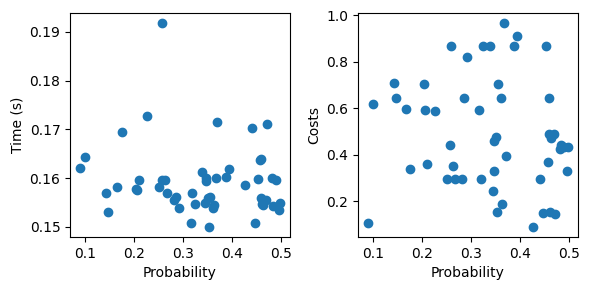

In [38]:
results = pd.read_csv("../results/german/dice_1sol.csv")
summarize_results(results, perc_calc, outlier_detection)

Time: 0.005 +- 0.002
Costs: 0.384 +- 0.237
Changes: 1.280 +- 0.607
Outliers: 0.380
Outliers score: 0.482 +- 0.044


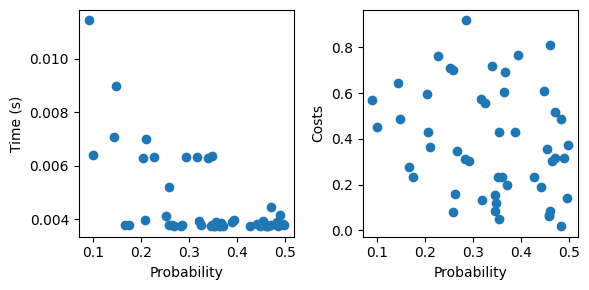

In [39]:
results = pd.read_csv("../results/german/nice_sol.csv")
summarize_results(results, perc_calc, outlier_detection)

Time: 1.909 +- 2.989
Costs: 0.139 +- 0.134
Changes: 2.000 +- 0.906
Outliers: 0.150
Outliers score: 0.468 +- 0.030


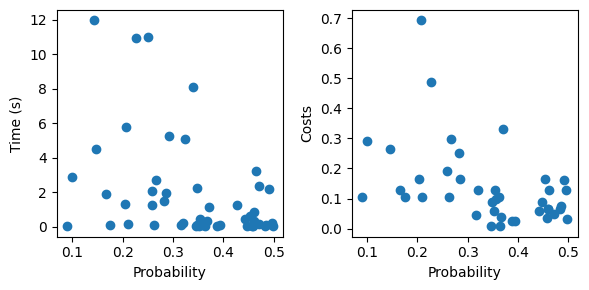

In [40]:
results = pd.read_csv("../results/german/mapofcem_percentile.csv")
summarize_results(results, perc_calc, outlier_detection)

Time: 0.830 +- nan
Costs: 0.193 +- nan
Changes: 3.000 +- nan
Outliers: 0.000
Outliers score: 0.455 +- nan


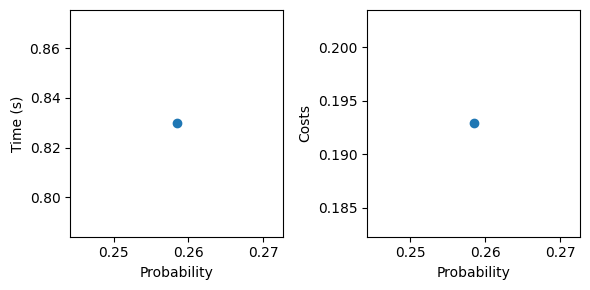

In [44]:
results = pd.read_csv("../results/german/mapocam_percentile.csv")
summarize_results(results, perc_calc, outlier_detection)

Time: 15.970 +- 0.827
Costs: 0.100 +- 0.079
Changes: 1.500 +- 0.789
Outliers: 0.520
Outliers score: 0.506 +- 0.049


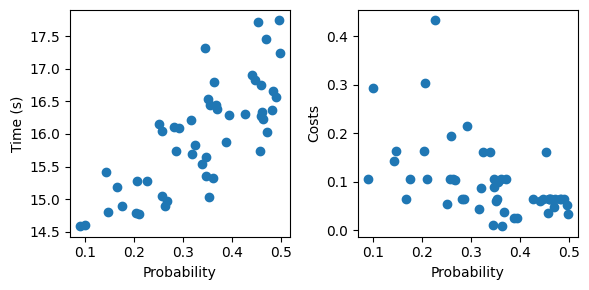

In [46]:
results = pd.read_csv("../results/german/bruteforce_percentiles.csv")
summarize_results(results, perc_calc, outlier_detection)

### Percentile of outliers

In [94]:
paths = "../results/german/"
methods = [f"mapofcem_percentile_outlier_{x}" for x in [0.005, 0.01, 0.05, 0.075, 0.1]] + [f"mapofcem_v2_percentile_outlier_{x}" for x in [0.005, 0.01, 0.05, 0.075, 0.1]]



results = []
for m in methods:
    results_saved = pd.read_csv(f"{paths}{m}.csv")
    results.append(summarize_results(results_saved, perc_calc, outlier_detection, display_results = False))
    results[-1]["method"] = m
results = pd.concat(results)
results["outlier_percentile"] = results["method"].apply(lambda x: float(x.split("_")[-1]))
results = results.groupby("method").agg({
    "time" : "mean", 
    "costs" : "mean",
    "n_changes" : "mean",
    "outlier" : "mean",
    "outliers_score" : "mean",
    "outlier_percentile" : "first"
})
results

,time,costs,n_changes,outlier,outliers_score,outlier_percentile
method,,,,,,
mapofcem_percentile_outlier_0.005,0.486426,0.100135,2.040000,0.160000,0.505442,0.005
mapofcem_percentile_outlier_0.01,0.490023,0.101604,2.040000,0.120000,0.503920,0.010
mapofcem_percentile_outlier_0.05,0.766175,0.105600,1.959184,0.040816,0.495132,0.050
mapofcem_percentile_outlier_0.075,0.996600,0.109533,1.978723,0.000000,0.493233,0.075
mapofcem_percentile_outlier_0.1,1.046290,0.108026,1.956522,0.000000,0.487919,0.100
mapofcem_v2_percentile_outlier_0.005,0.698909,0.100135,2.040000,0.160000,0.505442,0.005
mapofcem_v2_percentile_outlier_0.01,0.701074,0.101604,2.040000,0.120000,0.503920,0.010
mapofcem_v2_percentile_outlier_0.05,1.072000,0.105600,1.959184,0.040816,0.495132,0.050
mapofcem_v2_percentile_outlier_0.075,1.359492,0.109533,1.978723,0.000000,0.493233,0.075


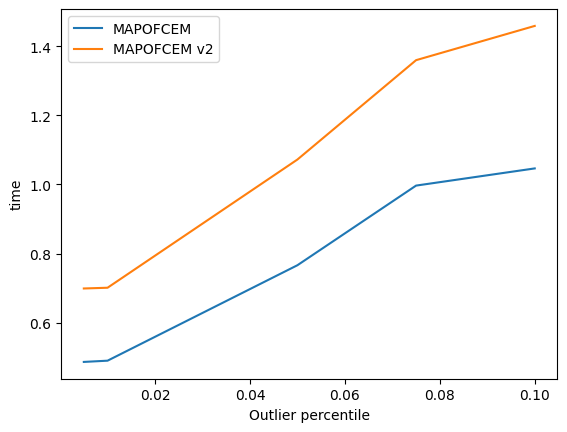

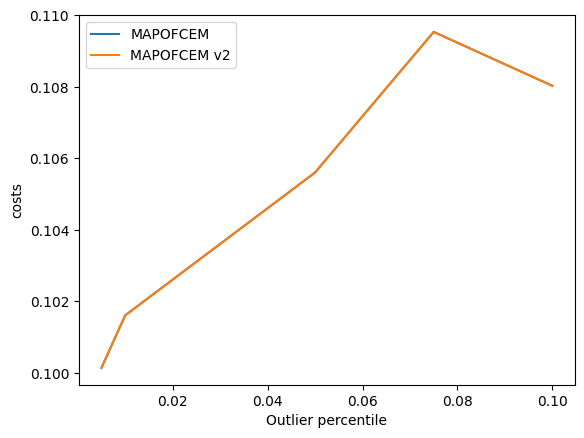

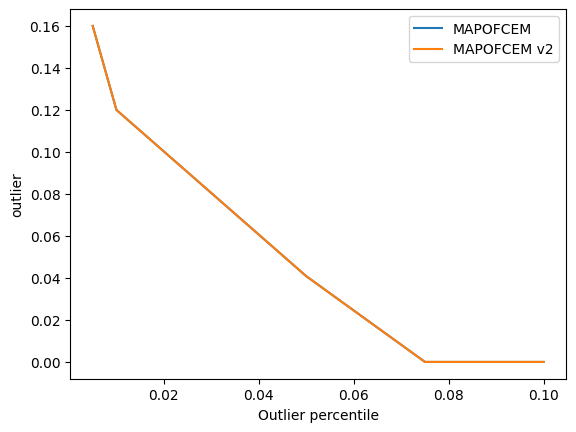

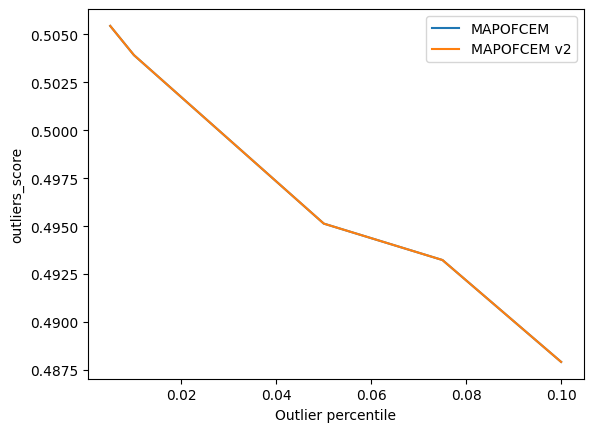

In [99]:
for col in ["time", "costs", "outlier", "outliers_score"]:
    plt.plot(results.head(5).outlier_percentile, results.head(5)[col],  label = "MAPOFCEM")
    plt.plot(results.tail(5).outlier_percentile, results.tail(5)[col],  label = "MAPOFCEM v2")
    plt.xlabel("Outlier percentile")
    plt.ylabel(col)
    plt.legend()
    plt.show()
    

## Taiwan

In [100]:
X_train, Y_train, model, _, individuals = get_data_model("taiwan")
X_train = X_train.astype(int)
individuals = individuals.astype(int)
outlier_detection = joblib.load("../models/taiwan/IsolationForest_test.pkl")

In [101]:
not_mutable_features = ['Single', 'Age_in_25_to_40', 'Married', 'Age_lt_25', 'Age_in_40_to_59', 'Age_geq_60', 'EducationLevel']
mutable_features = [feat for feat in X_train.columns if feat not in not_mutable_features]
action_set = ActionSet(X = X_train, default_step_size = 0.01, mutable_features = mutable_features)
perc_calc = PercentileCalculator(X = X_train)

In [84]:
paths = "../results/taiwan/"
methods = ["dice_1sol", "nice_sol", "mapofcem_percentile", "mapocam_percentile", "mapofcem_v2_percentile"]

results = []
for m in methods:
    results_saved = pd.read_csv(f"{paths}{m}.csv")
    results.append(summarize_results(results_saved, perc_calc, outlier_detection, display_results = False))
    results[-1]["method"] = m
results = pd.concat(results)
results.groupby("method").agg({
    "time" : "mean", 
    "costs" : "mean",
    "n_changes" : "mean",
    "outlier" : "mean",
    "outliers_score" : "mean"
})

,time,costs,n_changes,outlier,outliers_score
method,,,,,
dice_1sol,0.239568,0.683867,1.660000,0.620000,0.517464
mapocam_percentile,2.183914,0.094125,2.140000,0.200000,0.463459
mapofcem_percentile,24.530386,0.131146,2.227273,0.090909,0.445893
mapofcem_v2_percentile,26.334403,0.131146,2.227273,0.090909,0.445893
nice_sol,0.022121,0.316138,3.380000,0.180000,0.470046


Time: 0.240 +- 0.011
Costs: 0.684 +- 0.259
Changes: 1.660 +- 0.479
Outliers: 0.620
Outliers score: 0.517 +- 0.049


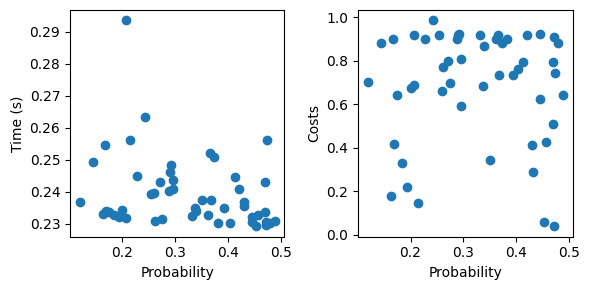

In [49]:
results = pd.read_csv("../results/taiwan/dice_1sol.csv")
summarize_results(results, perc_calc, outlier_detection)

Time: 0.022 +- 0.008
Costs: 0.316 +- 0.232
Changes: 3.380 +- 2.522
Outliers: 0.180
Outliers score: 0.470 +- 0.054


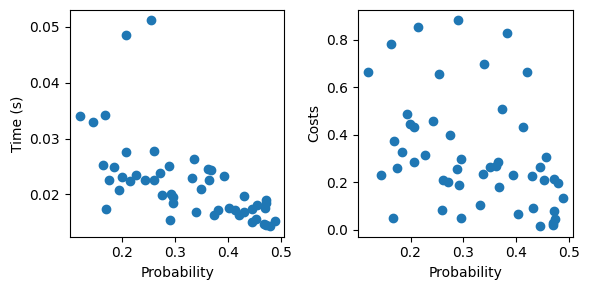

In [50]:
results = pd.read_csv("../results/taiwan/nice_sol.csv")
summarize_results(results, perc_calc, outlier_detection)

Time: 24.530 +- 71.087
Costs: 0.131 +- 0.162
Changes: 2.227 +- 0.937
Outliers: 0.091
Outliers score: 0.446 +- 0.029


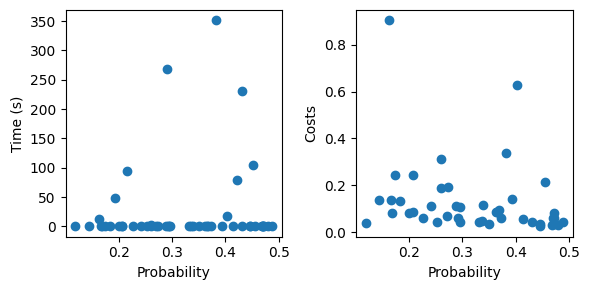

In [51]:
results = pd.read_csv("../results/taiwan/mapofcem_percentile.csv")
summarize_results(results, perc_calc, outlier_detection)

Time: 2.184 +- 7.253
Costs: 0.094 +- 0.109
Changes: 2.140 +- 0.948
Outliers: 0.200
Outliers score: 0.463 +- 0.053


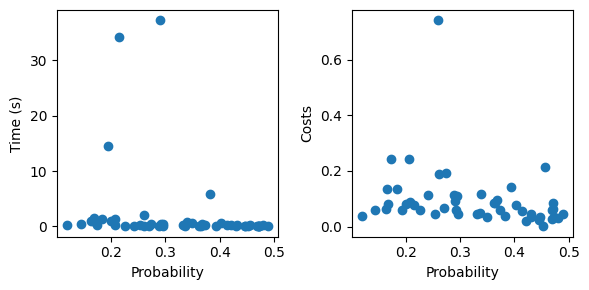

In [52]:
results = pd.read_csv("../results/taiwan/mapocam_percentile.csv")
summarize_results(results, perc_calc, outlier_detection)

In [30]:
results = pd.read_csv("../results/taiwan/bruteforce_percentile.csv")
summarize_results(results, outlier_detection)

AttributeError: 'OutlierWrap' object has no attribute 'percVec'

### Percentile of outliers

In [102]:
paths = "../results/taiwan/"
methods = [f"mapofcem_percentile_outlier_{x}" for x in [0.005, 0.01, 0.05, 0.075, 0.1]] + [f"mapofcem_v2_percentile_outlier_{x}" for x in [0.005, 0.01, 0.05, 0.075, 0.1]]



results = []
for m in methods:
    results_saved = pd.read_csv(f"{paths}{m}.csv")
    results.append(summarize_results(results_saved, perc_calc, outlier_detection, display_results = False))
    results[-1]["method"] = m
results = pd.concat(results)
results["outlier_percentile"] = results["method"].apply(lambda x: float(x.split("_")[-1]))
results = results.groupby("method").agg({
    "time" : "mean", 
    "costs" : "mean",
    "n_changes" : "mean",
    "outlier" : "mean",
    "outliers_score" : "mean",
    "outlier_percentile" : "first"
})
results

,time,costs,n_changes,outlier,outliers_score,outlier_percentile
method,,,,,,
mapofcem_percentile_outlier_0.005,1.185290,0.094125,2.140000,0.100000,0.463082,0.005
mapofcem_percentile_outlier_0.01,1.181183,0.094125,2.140000,0.100000,0.463082,0.010
mapofcem_percentile_outlier_0.05,13.434407,0.099128,2.250000,0.020833,0.455322,0.050
mapofcem_percentile_outlier_0.075,18.093981,0.117469,2.319149,0.000000,0.451579,0.075
mapofcem_percentile_outlier_0.1,29.556727,0.151469,2.319149,0.000000,0.450053,0.100
mapofcem_v2_percentile_outlier_0.005,1.353299,0.094125,2.140000,0.100000,0.463082,0.005
mapofcem_v2_percentile_outlier_0.01,1.323638,0.094125,2.140000,0.100000,0.463082,0.010
mapofcem_v2_percentile_outlier_0.05,14.319247,0.099128,2.250000,0.020833,0.455322,0.050
mapofcem_v2_percentile_outlier_0.075,19.357198,0.117469,2.319149,0.000000,0.451579,0.075


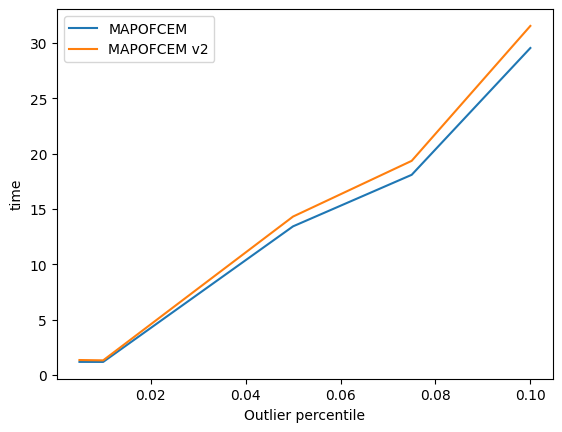

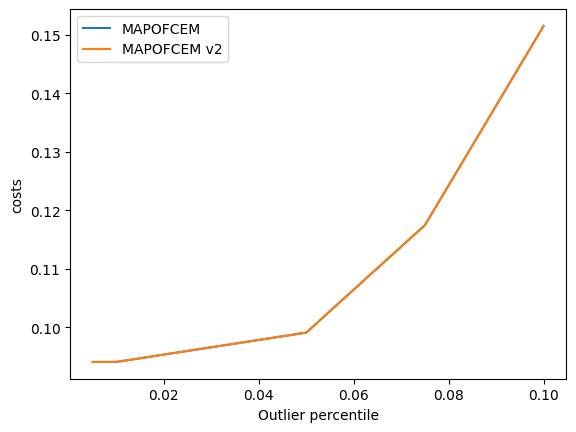

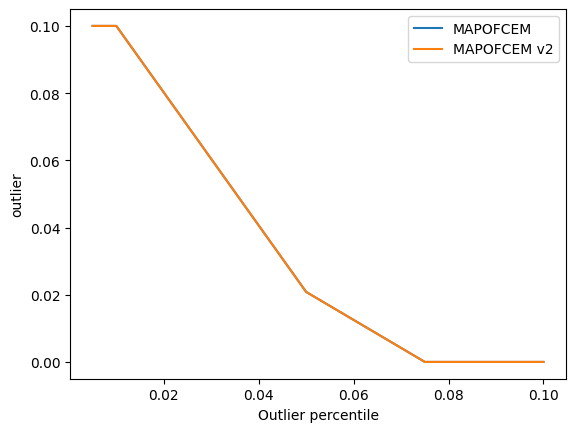

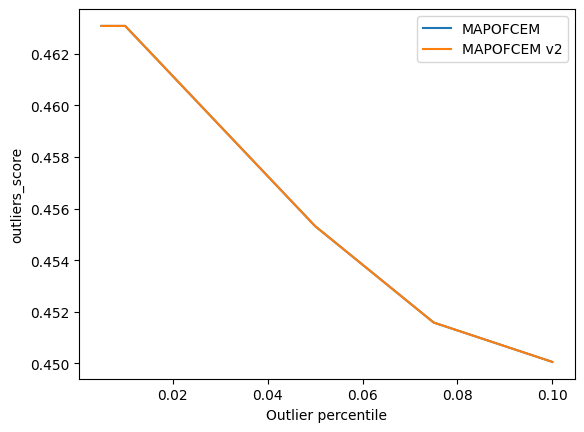

In [103]:
for col in ["time", "costs", "outlier", "outliers_score"]:
    plt.plot(results.head(5).outlier_percentile, results.head(5)[col],  label = "MAPOFCEM")
    plt.plot(results.tail(5).outlier_percentile, results.tail(5)[col],  label = "MAPOFCEM v2")
    plt.xlabel("Outlier percentile")
    plt.ylabel(col)
    plt.legend()
    plt.show()
    

## Step size analysis

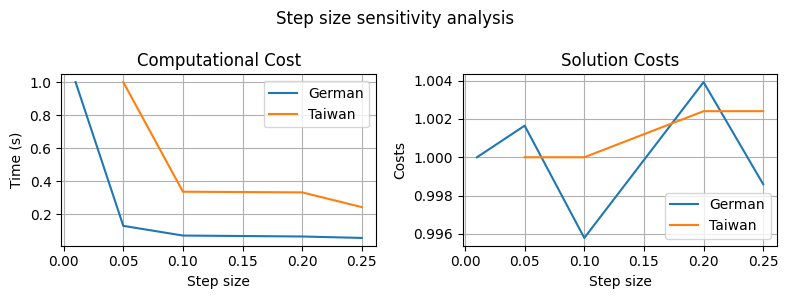

In [33]:
fig, axs  = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 3))

results_dict = []
for s in [1, 5, 10, 20, 25]:
    results = pd.read_csv(f"../results/german_step_size/mapofcem_{s}.csv")
    results = summarize_results(results, display_results=False)

    new_row = {}
    new_row["step_size"] = s/100
    new_row["time"] = results["time"].mean()
    new_row["time_std"] = results["time"].std()
    new_row["costs"] = results["costs"].mean()
    new_row["costs_std"] = results["costs"].std()
    results_dict.append(new_row)

results_dict = pd.DataFrame(results_dict)


# axs[0].fill_between(
#     results_dict["step_size"],
#     (results_dict["time"] - results_dict["time_std"]) / results_dict.time.iloc[0],
#     (results_dict["time"] + results_dict["time_std"]) / results_dict.time.iloc[0],
#     alpha = 0.3,
# )
axs[0].plot(results_dict["step_size"], results_dict["time"] / results_dict.time.iloc[0], label = "German")
axs[0].set_xlabel("Step size")
axs[0].set_ylabel("Time (s)")
#axs[0].set_yscale("log")

# axs[1].fill_between(
#     results_dict["step_size"],
#     (results_dict["costs"] - results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     (results_dict["costs"] + results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     alpha = 0.3,
# )
axs[1].plot(results_dict["step_size"], results_dict["costs"] / results_dict.costs.iloc[0], label = "German")
axs[1].set_xlabel("Step size")
axs[1].set_ylabel("Costs")


results_dict = []
for s in [5, 10, 20, 25]:
    results = pd.read_csv(f"../results/taiwan_step_size/mapofcem_{s}.csv")
    results = summarize_results(results, display_results=False)

    new_row = {}
    new_row["step_size"] = s/100
    new_row["time"] = results["time"].mean()
    new_row["time_std"] = results["time"].std()
    new_row["costs"] = results["costs"].mean()
    new_row["costs_std"] = results["costs"].std()
    results_dict.append(new_row)

results_dict = pd.DataFrame(results_dict)


# axs[0].fill_between(
#     results_dict["step_size"],
#     (results_dict["time"] - results_dict["time_std"]) / results_dict.time.iloc[0],
#     (results_dict["time"] + results_dict["time_std"]) / results_dict.time.iloc[0],
#     alpha = 0.3,
# )
axs[0].plot(results_dict["step_size"], results_dict["time"] / results_dict.time.iloc[0], label = "Taiwan")
axs[0].set_xlabel("Step size")
axs[0].set_ylabel("Time (s)")
#axs[0].set_yscale("log")

# axs[1].fill_between(
#     results_dict["step_size"],
#     (results_dict["costs"] - results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     (results_dict["costs"] + results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     alpha = 0.3,
# )
axs[1].plot(results_dict["step_size"], results_dict["costs"] / results_dict.costs.iloc[0], label = "Taiwan")
axs[1].set_xlabel("Step size")
axs[1].set_ylabel("Costs")


for i in range(2):
    axs[i].legend()
    axs[i].grid()

axs[0].set_title("Computational Cost")
axs[1].set_title("Solution Costs")

plt.suptitle("Step size sensitivity analysis")
plt.tight_layout()
plt.show()